# PMOIRED model syntax with illustration

`PMOIRED` uses Python dictionnaries `{key:value, ...}` where `key` can only be stringes and `value` can be either a number, or a string. `PMOIRED` guesses what the model is solely based on the keys of the dictionnary. This notebook showcases the various basic models, as well how to combine them. 

- [Basic models](#basic)
- [Simple geometric transformations](#transform)
- [Azimuthal variations](#az)
- [Convolve by a spatial kernel](#kern)
- [Combining components](#combining)
- [Expressing parameters as function as others](#params)
- [Spectral lines](#lines")
- [Simulating VLTI observations from model](#simu)

In [1]:
#%matplotlib widget
import pmoired
import numpy as np
from matplotlib import pyplot as plt
# -- dummy wavelength vector for display
WL = np.linspace(1,3,10)
oi = pmoired.OI() # empty object (no data)

## Basic models <a id="basic"></a>

The basic buiding blocks are as followed. All dimensions are in milli-arcseconds:
- uniform disk {`ud`}
- disk with arbitrary profile {`diam`, `profile`}
- ring with arbitrary profile {`diamin`, `diamout`, `profile`} or {`diam`, `thick`, `profile`}. In the later case, `diam` is the outer diameter, and `thick` is the thickness from 0 (infinitely thin) and 1 (filled disk)
- Gaussian {`fwhm`}
- Crescent {`crin`, `crout`, `croff`, `crprojang`} for the inner and outer diameter (mas), the offset of inner to outer limits (0..1) and the projection angle of the thinest part (degrees, 0==N, 90==E)
- Gaussian ring define by inner and outer full width at half maximum {`fwhmin`, `fwhmout`}
- if none of the above, the component is a fully resolved (i.e. 0 visibility at all baselines)

`profile` is a string which defines the radial profile as function of `$R` (radius, in mas), `$D` (diameter in mas) or `$MU`=$\sqrt{1-r^2/r_{max}^2}$. Note that the absolute value of `profile` does not matter: the flux of the model if defined by `f` or `spectrum`

In addition, you can define:
- `f` as the flux of the component
- `x` and `y` the positions (`x` towards East in mas, `y` towards North in mas)
- `incl`, `projang` the inclination and projection angle in degrees. The projection angle is defines a 0==N, 90==E. The image will compressed by a factor cosine(inclination) in the direction perpendicular to projection angle 
- pairs of `az amp`i, `az projang`i for harmonic azimuthal variations or order i (not for Gaussians). if overall `projang` is defined, `az projang`i are defined with respect to the global projection angle. 


# Simple geometric transformations <a id="transform"></a>

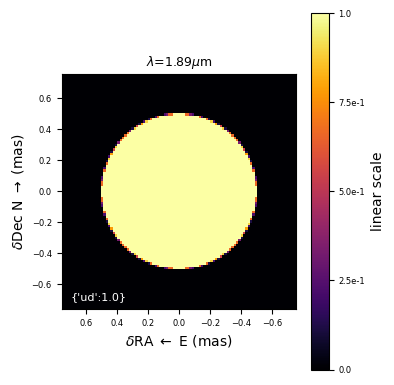

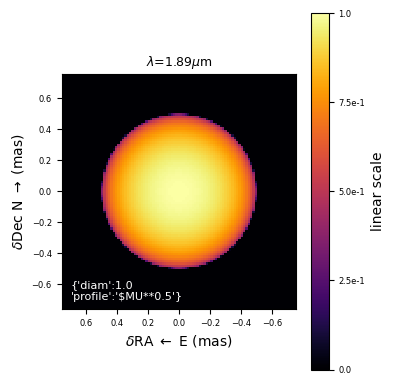

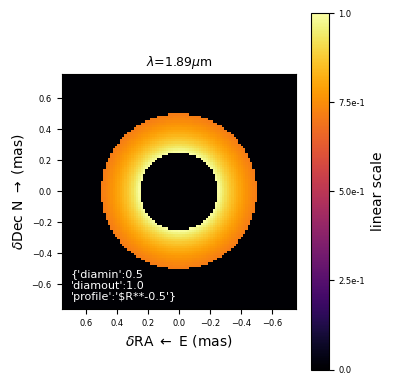

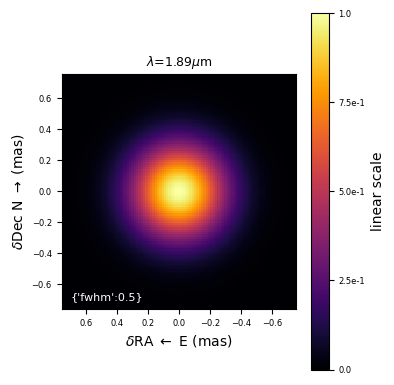

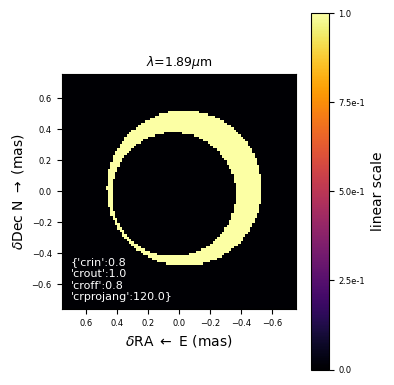

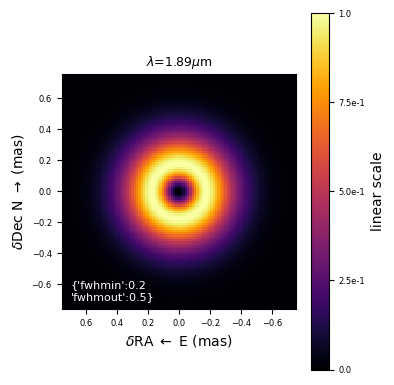

In [2]:
for model in [{'ud':1}, 
              {'diam':1, 'profile':'$MU**0.5'}, 
              {'diamin':0.5, 'diamout':1, 'profile':'$R**-0.5'},
              {'fwhm':0.5}, 
              {'crin':0.8, 'crout':1, 'croff':0.8, 'crprojang':120},
              {'fwhmin':0.2, 'fwhmout':.5},
             ]:
    # -- show just the image: Field of view "imFov" has to be defined
    oi.showModel(model, WL=WL, imFov=1.5, showSED=False)
    # -- optional: overlay model dict on the plot
    t = plt.text(0.7, -0.7, '{'+'\n'.join(["'%s':'%s'"%(k, model[k].replace('$', r'\$')) if type(model[k])==str else "'%s':%.1f"%(k, model[k]) for k in model])+'}', 
                 color='w', in_layout=True, fontsize=8, ha='left')

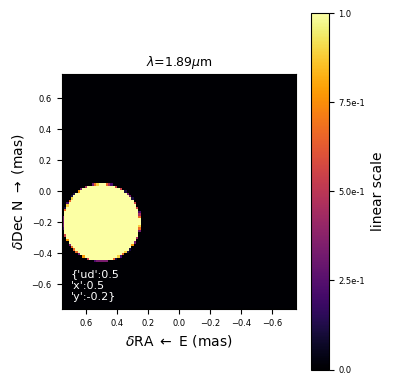

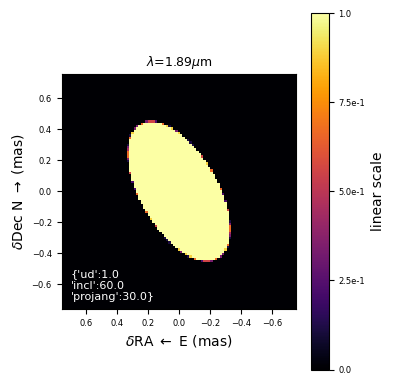

In [3]:
for model in [{'ud':0.5, 'x':.5, 'y':-0.2}, 
              {'ud':1.0, 'incl':60, 'projang':30} 
             ]:
    # -- show just the image: Field of view "imFov" has to be defined
    oi.showModel(model, WL=WL, imFov=1.5, showSED=False)
    # -- optional: overlay model dict on the plot
    t = plt.text(0.7, -0.7, '{'+'\n'.join(["'%s':'%s'"%(k, model[k].replace('$', r'\$')) if type(model[k])==str else "'%s':%.1f"%(k, model[k]) for k in model])+'}', 
             color='w', in_layout=True, fontsize=8, ha='left')

# Azimuthal variations <a id="az"></a>

Azimuthal variations are available for disks (`{'diam':}`, with and without `'profile'`), rings (`{'diamin':, 'diamout':}`, with and without `'profile'`) and Gaussian rings (`{'fwhmin':, 'fwhmout':}`)

{'diamin': 1, 'diamout': 3, 'projang': -20, 'incl': 60, 'az amp1': 0.3333333333333333, 'az projang1': 30, 'az amp2': 0.3333333333333333, 'az projang2': 60, 'az amp3': 0.3333333333333333, 'az projang3': 90}


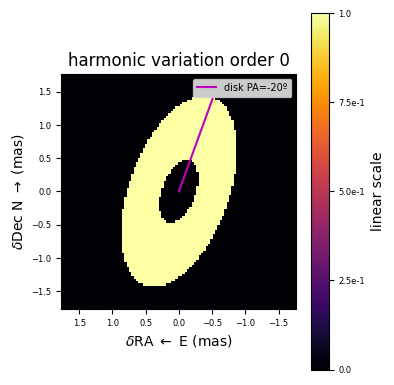

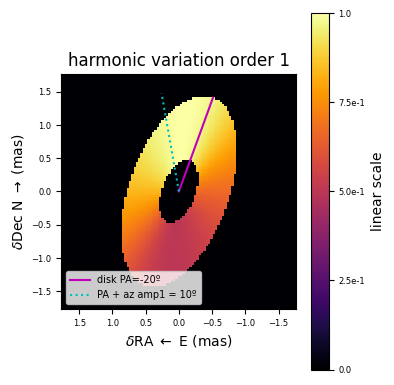

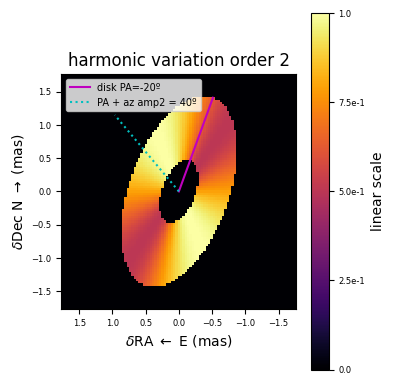

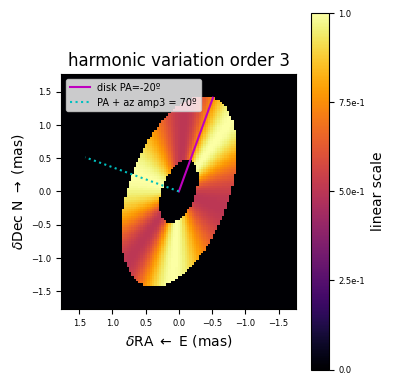

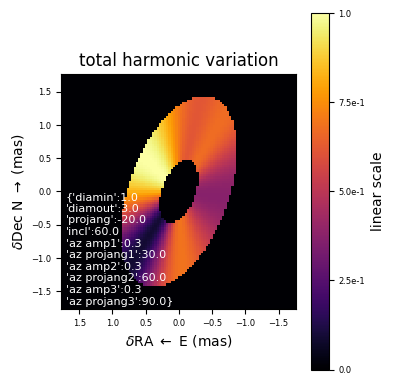

In [4]:
# -- dummy wavelength vector for display
WL = np.linspace(1,2,10)
oi = pmoired.OI()

# -- harmonics orders:
Is = [1,2,3]

# -- single harmonic azimuthal variation
for i in [0]+Is:
  model = {'diamin':1, 
          'diamout':3, 
          'projang':-20, 
          'incl':60}
  if i>0:
    model.update({'az amp%d'%i:1/len(Is), 'az projang%d'%i:i*30})
  oi.showModel(model, WL=WL, imFov=3.5, showSED=False)
  # -- show PA:
  plt.plot([0, model['diamout']/2*np.sin(np.pi/180*(model['projang']))],
           [0, model['diamout']/2*np.cos(np.pi/180*(model['projang']))],
            '-m', label='disk PA=%.0fº'%model['projang'])
  if i>0:
    plt.plot([0, model['diamout']/2*np.sin(np.pi/180*(model['projang']+model['az projang%d'%i]))],
             [0, model['diamout']/2*np.cos(np.pi/180*(model['projang']+model['az projang%d'%i]))],
            ':c', label='PA + az amp%d = %.0fº'%(i, model['projang']+model['az projang%d'%i]))
  plt.legend(fontsize=7)
  plt.title('harmonic variation order %d'%i)

# -- total harmonic variation
model = {'diamin':1, 
        'diamout':3, 
        'projang':-20, 
        'incl':60}
for i in Is:
  model.update({'az amp%d'%i:1/len(Is), 'az projang%d'%i:i*30})
print(model)
oi.showModel(model, WL=WL, imFov=3.5, showSED=False)
plt.title('total harmonic variation')
t = plt.text(1.7, -1.7, '{'+'\n'.join(["'%s':'%s'"%(k, model[k].replace('$', r'\$')) if type(model[k])==str else "'%s':%.1f"%(k, model[k]) for k in model])+'}', 
             color='w', in_layout=True, fontsize=8, ha='left')

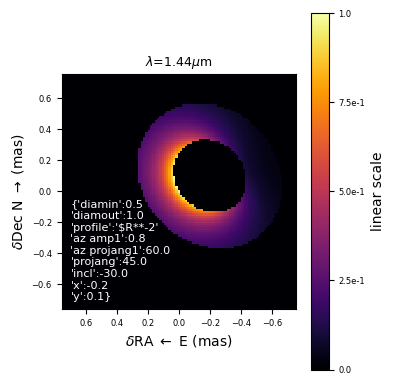

In [5]:
model = {'diamin':0.5, 'diamout':1, 'profile':'$R**-2', 'az amp1':0.8, 'az projang1':60, 'projang':45, 'incl':-30, 'x':-0.2, 'y':0.1}

# -- show just the image: Field of view "imFov" has to be defined
oi.showModel(model, WL=WL, imFov=1.5, showSED=False)
# -- optional: overlay model dict on the plot
t = plt.text(0.7, -0.7, '{'+'\n'.join(["'%s':'%s'"%(k, model[k].replace('$', r'\$')) if type(model[k])==str else "'%s':%.1f"%(k, model[k]) for k in model])+'}', 
         color='w', in_layout=True, fontsize=8, ha='left')

# Convolve by a spatial kernel <a id="kern"></a>

Some shapes have sharp edges, which translates into high frequency in the visibility space. When fitting, this means that bot low and high frequencies (visibilities for short and large baselines) are affected by the same parameters. To lower the contribution of high frequencies, one can use a spatial kernel to smooth out the image. The kernel is a Gaussian one, defined by its full width at half max, in mas.

There is no numerical penalty in using a kernel, as the convolution in image space corresponds to a multiplication in Fourier space, and the FT of the Gaussian is analyticaly determined.

When fitting, it is best to leave the the spatial kernel fixed. 

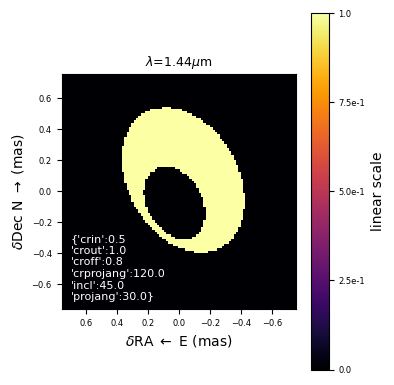

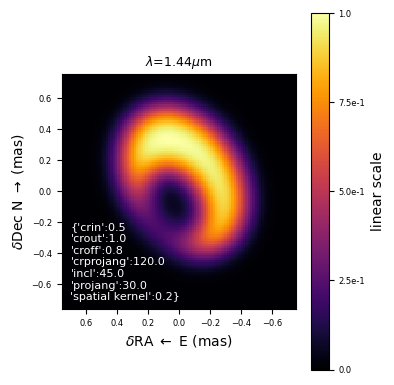

In [6]:
for model in [{'crin':0.5, 'crout':1, 'croff':0.8, 'crprojang':120, 'incl':45, 'projang':30},
              {'crin':0.5, 'crout':1, 'croff':0.8, 'crprojang':120, 'incl':45, 'projang':30, 'spatial kernel':0.2},
             ]:
    # -- show just the image: Field of view "imFov" has to be defined
    oi.showModel(model, WL=WL, imFov=1.5, showSED=False)
    # -- optional: overlay model dict on the plot
    t = plt.text(0.7, -0.7, '{'+'\n'.join(["'%s':'%s'"%(k, model[k].replace('$', r'\$')) if type(model[k])==str else "'%s':%.1f"%(k, model[k]) for k in model])+'}', 
                 color='w', in_layout=True, fontsize=8, ha='left')

# Combining components <a id="combining"></a>

models can be combined using a single dictionary, where keys are `componenent,parameter`. The fluxes and spectra are total, and the `profile` do not change the absolute surface brightness of the component. Any flux in  `PMOIRED` is the total flux of a component, not its surface brightness. 

The total flux of each component is by default equal to 1. Unless you fit also the SED or the normalised flux, only relative fluxes are important (in this case, one should always set at least one flux not fitted). The key `f` define the total flux (that is an achromatic flux spectral density). `spectum` allows to define arbitray spectra as string, using the special string `$WL` to refere to the wavelength in microns. 

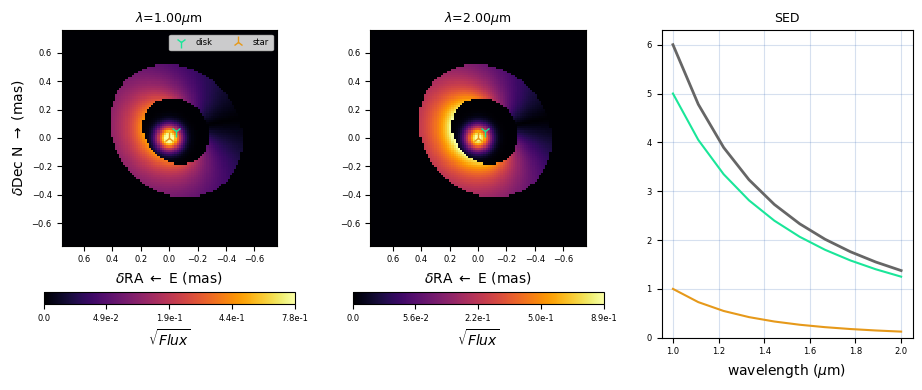

In [7]:
model = {'disk,diamin':0.5, 
         'disk,diamout':1, 
         'disk,profile':'$R**-2', 
         'disk,az amp1':1, 
         'disk,az projang1':60, 
         'disk,projang':45, 
         'disk,incl':-30, 
         'disk,x':-0.05, 
         'disk,y':0.05, 
         'disk,spectrum':'5*($WL)**-2',
         'star,fwhm':0.1, 
         'star,spectrum':'$WL**-3', 
        }

# -- show just the image: Field of view "imFov" has to be defined
# -- imMax='95' means it cuts at the 95 percentile of the surface brightness
oi.showModel(model, WL=WL, imFov=1.5, showSED=True, imMax='99.9', imPow=0.5, imWl0=[1.0, 3.0])

# Expressing parameters as function as others <a id="params"></a>

In the dictionary, you can express parameters as function as others, using a strong as definition, and preceding the parameters's name with `$`. One can even define global parameters. This can also be used to define the radial profiles of disks (`profile`), as well as spectra (`spectrum`). 

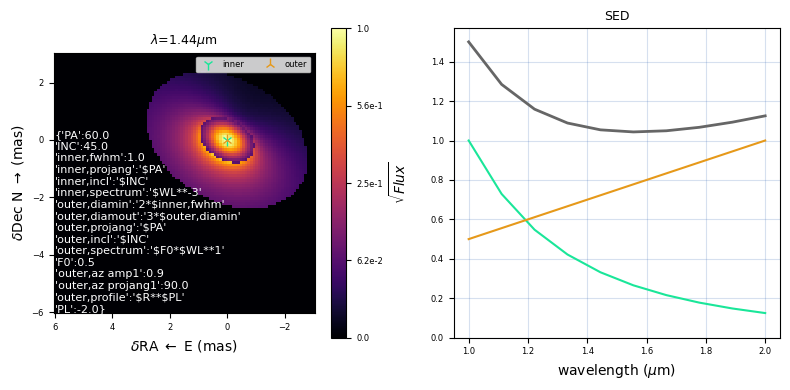

In [8]:
model = {'PA':60, 
         'INC':45,
         'inner,fwhm':1, 
         'inner,projang':'$PA', 
         'inner,incl':'$INC',
         'inner,spectrum':'$WL**-3', 
         'outer,diamin':'2*$inner,fwhm', 
         'outer,diamout':'3*$outer,diamin', 
         'outer,projang':'$PA', 
         'outer,incl':'$INC', 
         'outer,spectrum':'$F0*$WL**1', 
         'F0':0.5,
         'outer,az amp1': 0.9,
         'outer,az projang1': 90,
         'outer,profile':'$R**$PL', 
         'PL':-2}
oi.showModel(model, WL=WL, imFov=9, showSED=True, imPow=0.5, imX=1.5, imY=-1.5)
t = oi._modelAxes['images'][0].text(6, -6, '{'+'\n'.join(["'%s':'%s'"%(k, model[k].replace('$', r'\$')) if type(model[k])==str else "'%s':%.1f"%(k, model[k]) for k in model])+'}', 
         color='w', in_layout=True, fontsize=8, ha='left')

## how to make a spiral

Models can be generated with a loop, to define many components. Here we define N=5 nested rings with common incination and position angle, with azimuthal variations defined to mimic a Archimedes spiral. We add a spatial kernel to smooth out the high frequencies.

{'Din': 1,
 'Dout': 7,
 'INCL': 45,
 'PROJANG': 60,
 'pitch': 60,
 'PAin': -45,
 'ring0,diamin': '$Din + 0/5*($Dout-$Din)',
 'ring0,diamout': '$Din + 1/5*($Dout-$Din)',
 'ring0,az amp1': 1,
 'ring0,az projang1': '$PAin + $pitch*$ring0,diamin',
 'ring0,incl': '$INCL',
 'ring0,projang': '$PROJANG',
 'ring1,diamin': '$Din + 1/5*($Dout-$Din)',
 'ring1,diamout': '$Din + 2/5*($Dout-$Din)',
 'ring1,az amp1': 1,
 'ring1,az projang1': '$PAin + $pitch*$ring1,diamin',
 'ring1,incl': '$INCL',
 'ring1,projang': '$PROJANG',
 'ring2,diamin': '$Din + 2/5*($Dout-$Din)',
 'ring2,diamout': '$Din + 3/5*($Dout-$Din)',
 'ring2,az amp1': 1,
 'ring2,az projang1': '$PAin + $pitch*$ring2,diamin',
 'ring2,incl': '$INCL',
 'ring2,projang': '$PROJANG',
 'ring3,diamin': '$Din + 3/5*($Dout-$Din)',
 'ring3,diamout': '$Din + 4/5*($Dout-$Din)',
 'ring3,az amp1': 1,
 'ring3,az projang1': '$PAin + $pitch*$ring3,diamin',
 'ring3,incl': '$INCL',
 'ring3,projang': '$PROJANG',
 'ring4,diamin': '$Din + 4/5*($Dout-$Din)',
 'ri

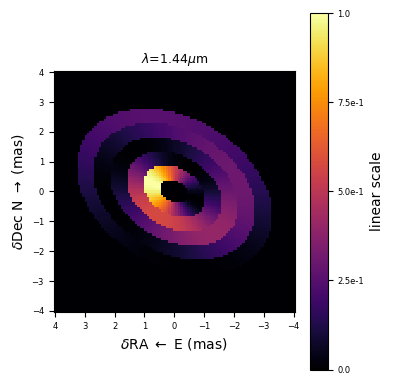

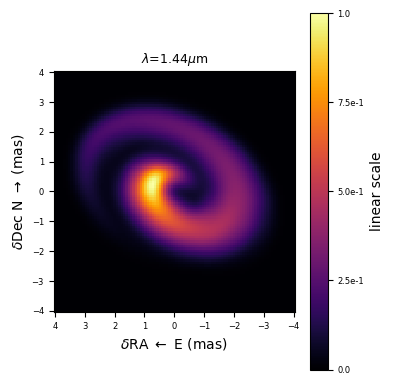

In [9]:
N = 5
model = {'Din':1, 'Dout':7, 'INCL':45, 'PROJANG':60, 'pitch':60, 'PAin':-45}
for i in range(N):
    k = 'ring'+str(i)+','
    model.update({k+'diamin': '$Din + %d/%d*($Dout-$Din)'%(i, N),
              k+'diamout': '$Din + %d/%d*($Dout-$Din)'%(i+1, N),
              k+'az amp1':1, k+'az projang1':'$PAin + $pitch*$%sdiamin'%k,               
              k+'incl':'$INCL', k+'projang':'$PROJANG', 
             })
display(model)
oi.showModel(model, WL=WL, imFov=8, showSED=False, imLegend=False)
model['spatial kernel'] = '0.5*($Dout-$Din)/%d'%N
oi.showModel(model, WL=WL, imFov=8, showSED=False, imLegend=False)


# Spectral lines <a id="lines"></a>

spectral lines can be defined as gaussians or lorentzian. A given component can have as many lines as needed. The line parameters starts with `line_` followed by a user defined name of the line (`x` below), followed by the parameter's name, starting with `_`. 
- `line_x_wl0`: central wavelength in microns
- `line_x_lorentzian` or `line_x_gaussian`: full width at half maximum, in nanometers
- `line_x_f`: amplitude of the line. Positive for an emission line, negative for an absorption line.

The line(s) will add up to the other flux definition. Remember that if no `f` or `spectrum` is defined, the flux will be set to `{'f':1}` by default. 

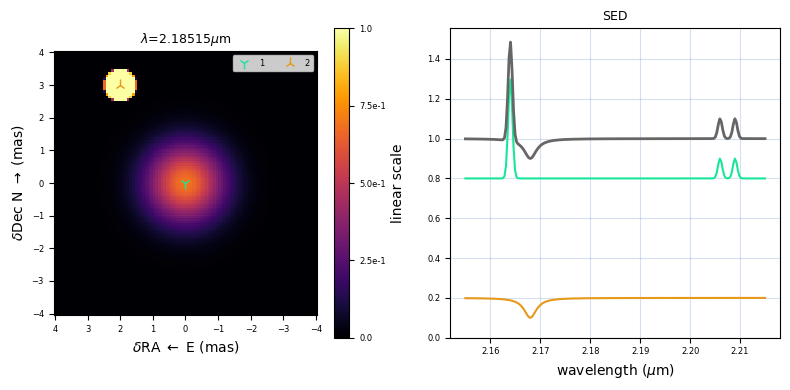

In [10]:
model = {'1,fwhm':2, 
         '1,f':0.8, 
         '1,line_Brg_wl0':2.164, 
         '1,line_Brg_gaussian':1, 
         '1,line_Brg_f':0.5,
         '1,line_Na1_wl0':2.206, 
         '1,line_Na1_gaussian':1, 
         '1,line_Na1_f':0.1,
         '1,line_Na2_wl0':2.209, 
         '1,line_Na2_gaussian':1, 
         '1,line_Na2_f':0.1,
         '2,ud':1, 
         '2,f':0.2,
         '2,line_Brg_wl0':2.168, 
         '2,line_Brg_lorentzian':3, 
         '2,line_Brg_f':-0.1,
         '2,x':2, '2,y':3,
        }

# -- wavelength vector (in um)
WLk = np.linspace(2.155, 2.215, 200)
#display(model)
oi=pmoired.OI()
oi.showModel(model, WL=WLk, imFov=8, showSED=True, imMax='99')

# simulating VLTI observations from model <a id="simu"></a>

The `PMOIRED` submodule `oifake` allows to generate simulated VLTI data, providing a telescope configuration (using a list of stations), a set of coordinates `(RA.h, DEC.d)`, a list of LST observations times (in hours), and a list of wavelength (in microns).



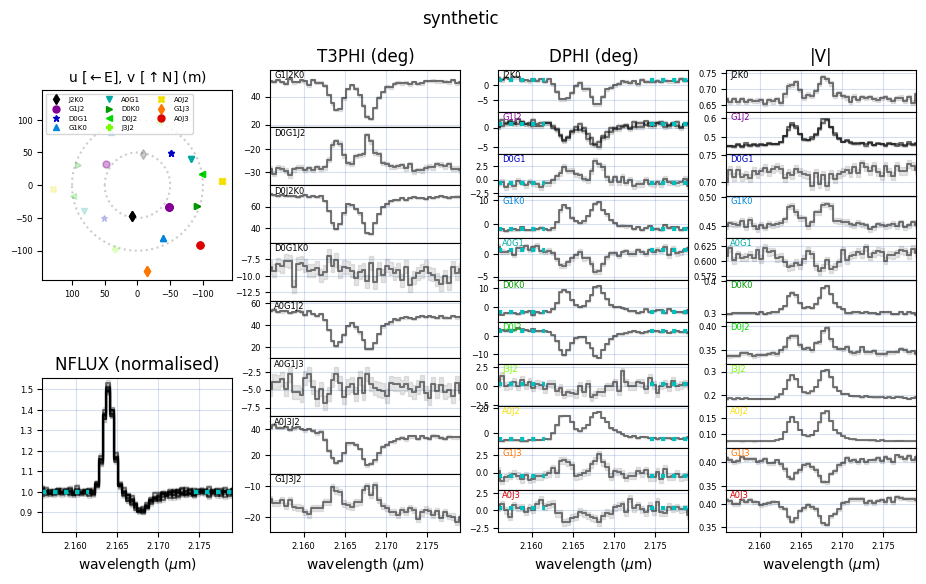

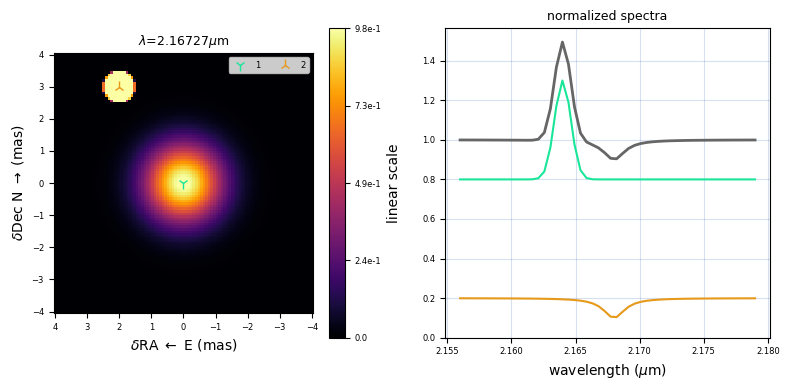

In [11]:
from importlib import reload
reload(pmoired.oimodels)
reload(pmoired.oifake)

model = {'1,fwhm':2, 
         '1,f':0.8, 
         '1,line_Brg_wl0':2.164, 
         '1,line_Brg_gaussian':1.5, 
         '1,line_Brg_f':0.5,
         '2,ud':1, 
         '2,f':0.2,
         '2,line_Brg_wl0':2.168, 
         '2,line_Brg_lorentzian':2, 
         '2,line_Brg_f':-0.1,
         '2,x':2, '2,y':3,
        }

# -- wavelength vector to simulate data (in um)
WLk = np.linspace(2.156, 2.179, 50)

# -- list of sidereal time of observations (hours): must be a list or np.ndarray
lst = [0] 
# -- create empty OI object
oif = pmoired.OI()
oif.fig=100

# -- note that oi.data must be a list: 
oif.data = [pmoired.oifake.makeFakeVLTI(['A0','G1','J3','J2'], target=(0, -32), lst=lst, wl=WLk, model=model),
            pmoired.oifake.makeFakeVLTI(['D0','G1','J2','K0'], target=(0, -32), lst=lst, wl=WLk, model=model)
           ]
# -- set manually the polynomial order for the continuum fit for diff. phase to 1 (default=2)
oif.setupFit({'obs':['NFLUX', 'T3PHI', 'DPHI', '|V|'],
             'DPHI order':1
             })
oif.show()
oif.showModel(model, WL=WLk, imFov=8, showSED=True, imMax='99')